In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import json

In [9]:
# args
model_names = ["gpt-4o-mini", "Qwen2.5-7B-Instruct", "Llama-3.1-8B-Instruct"]
dataset_names = ["gsm8k", "medqa_us", "triviaqa"]
results_dir = "results"
calibrated_file = "results_calibrate_True.json"
non_calibrated_file = "results_calibrate_False.json"

In [7]:
def acc_output(path: str):
    with open(path, "r") as f:
        data = json.load(f)
    print(np.mean(data["acc"]))

In [8]:
# trivia_qa
dataset_name = "triviaqa"
model_name = ["Llama-3.1-8B-Instruct", "Qwen2.5-7B-Instruct"]
for model in model_name:

    p = f"{dataset_name}/{model}/results.json"
    print(f"======================")
    print(f"Model: {model}")
    acc_output(p)

Model: Llama-3.1-8B-Instruct
0.8091473743647657
Model: Qwen2.5-7B-Instruct
0.660631143300569


### CDF

In [24]:
LINE_STYLES = {
    "Uncalibrated": {"color": "#E64B35", "linestyle": "-", "lw": 2},
    "Calibrated": {"color": "#357EBD", "linestyle": "--", "lw": 2},
}


def plot_cdf(ax, model_name, dataset_name):
    # 1. read data
    with open(f"{results_dir}/{model_name}/{dataset_name}/{calibrated_file}", "r") as f:
        data = json.load(f)["data"]  # 校准后数据
        cal = [min(x["confidence"], 100) for x in data]
    with open(
        f"{results_dir}/{model_name}/{dataset_name}/{non_calibrated_file}", "r"
    ) as f:
        data = json.load(f)["data"]  # 未校准数据
        noc = [min(x["confidence"], 100) for x in data]

    # 2. data preprocess
    cal_sorted = np.sort(cal)
    noc_sorted = np.sort(noc)

    # 3. generate cumulative probability axis (0-1)
    cal_cumprob = np.linspace(0, 1, len(cal_sorted))
    noc_cumprob = np.linspace(0, 1, len(noc_sorted))

    ax.plot(noc_sorted, noc_cumprob, **LINE_STYLES["Uncalibrated"])
    ax.plot(cal_sorted, cal_cumprob, **LINE_STYLES["Calibrated"])

    ax.set_xlabel("Confidence Score", fontsize=12)
    ax.set_ylabel("Cumulative Probability", fontsize=12)
    # ax.set_title(f"CDF of Confidence Scores ({model_name}, {dataset_name})", fontsize=14)
    ax.grid(True, alpha=0.3)

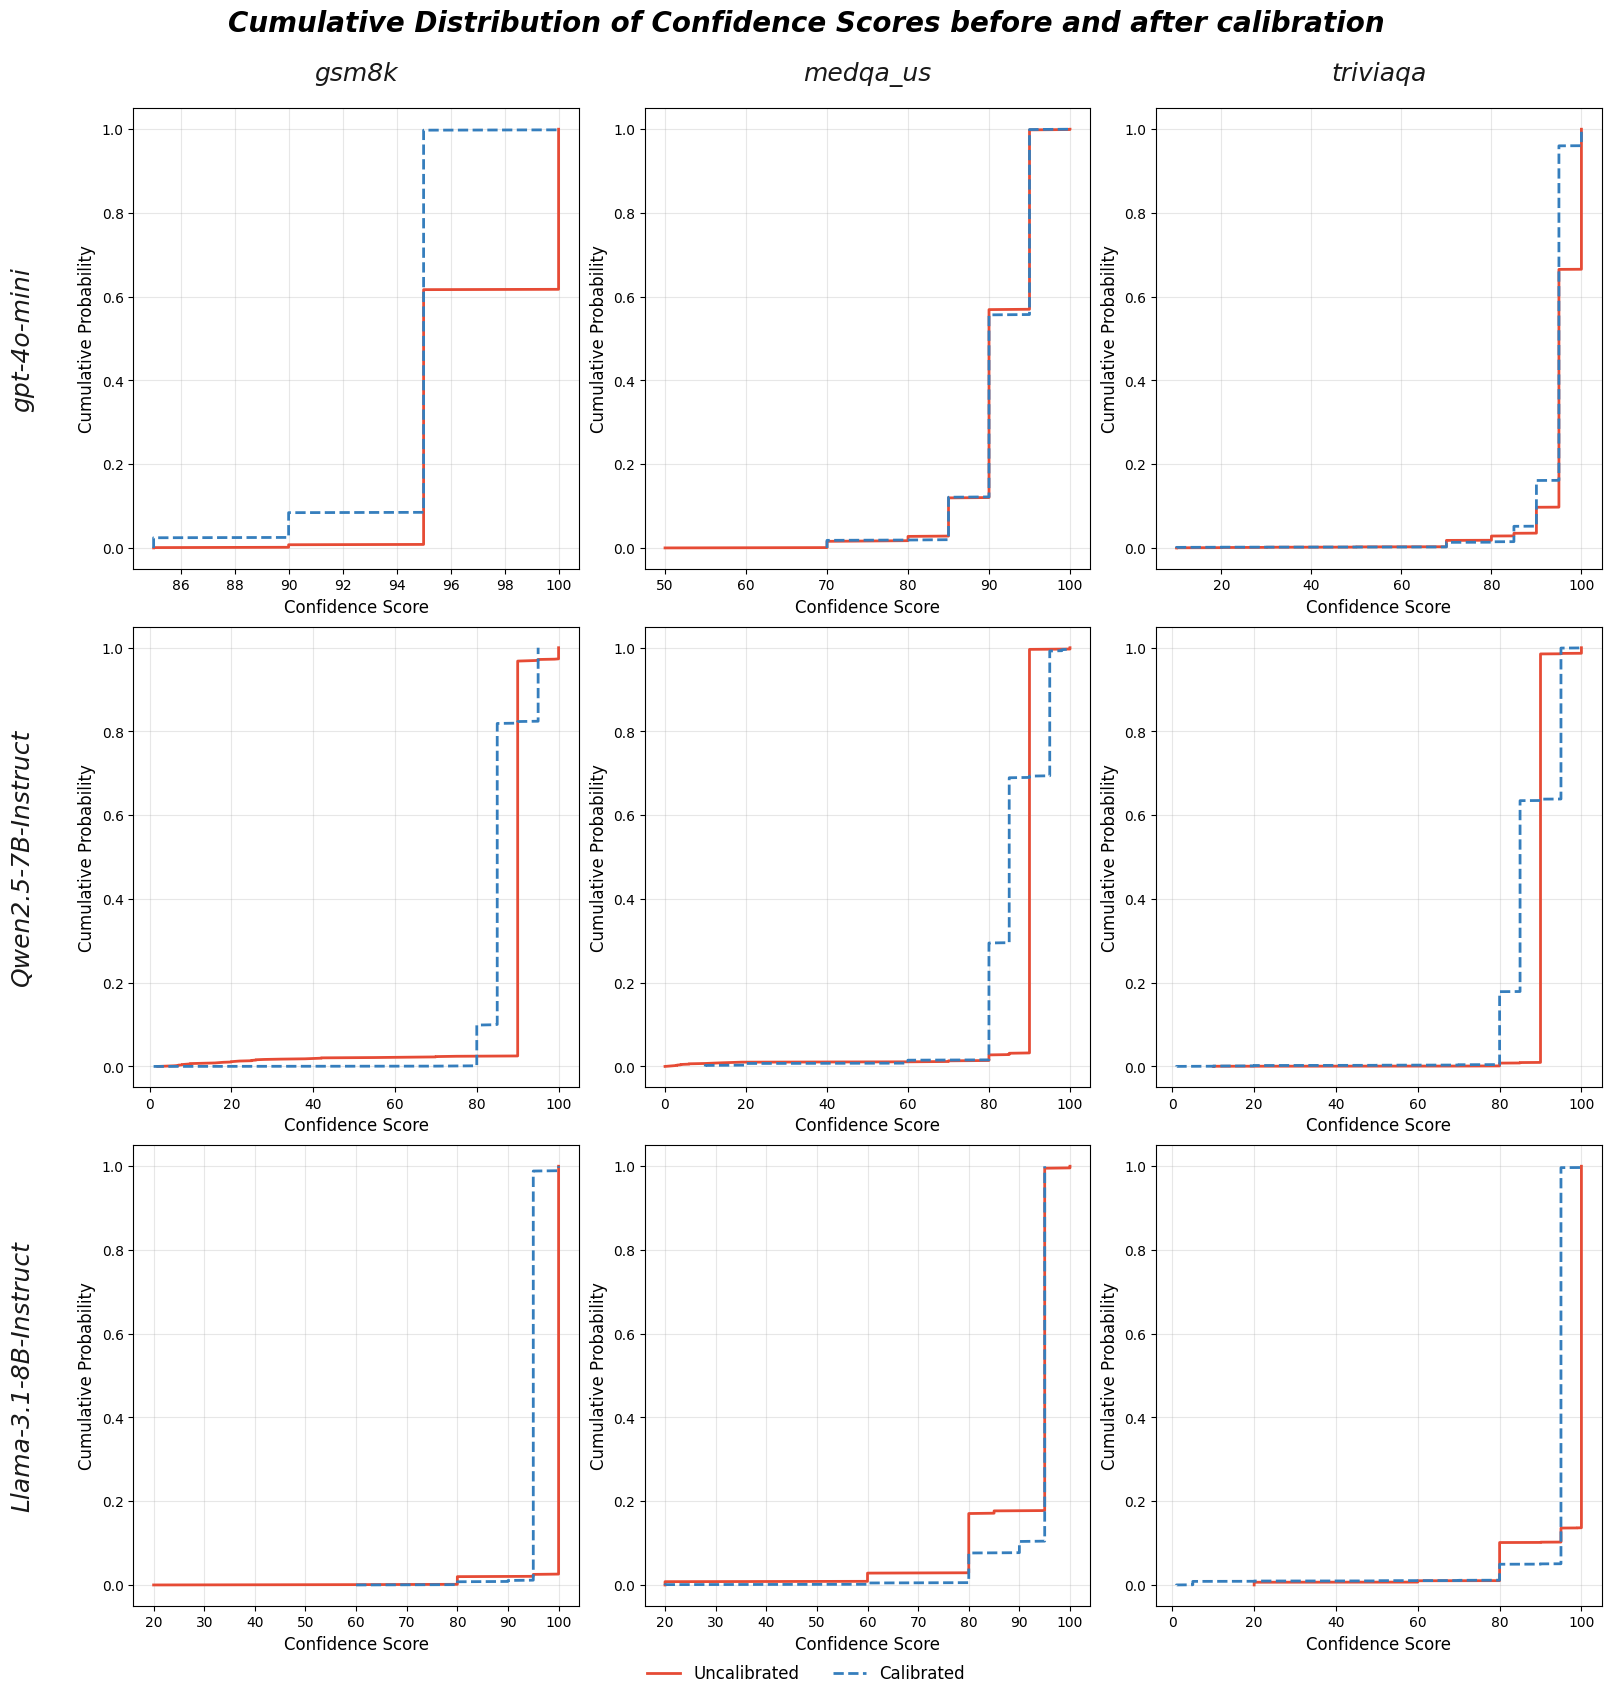

In [41]:
fig, axes = plt.subplots(
    len(model_names),
    len(dataset_names),
    layout="constrained",
    figsize=(16, 16),
    squeeze=False,
)
for i, model_name in enumerate(model_names):
    for j, dataset in enumerate(dataset_names):
        plot_cdf(axes[i, j], model_name, dataset)

for i, model_name in enumerate(model_names):
    axes[i, 0].text(
        x=-0.25,
        y=0.5,
        s=f"{model_name}",
        fontsize=18,
        rotation=90,
        transform=axes[i, 0].transAxes,
        va="center",
        ha="center",
        fontstyle="italic",
        alpha=0.9,
    )

for j, dataset in enumerate(dataset_names):
    axes[0, j].set_title(
        f"{dataset}", fontsize=18, pad=20, fontstyle="italic", alpha=0.9
    )

fig.legend(
    handles=[
        plt.Line2D([], [], **LINE_STYLES["Uncalibrated"]),
        plt.Line2D([], [], **LINE_STYLES["Calibrated"]),
    ],
    labels=["Uncalibrated", "Calibrated"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.025),  # 调整图例位置到主图上方
    ncol=2,
    fontsize=12,
    frameon=False,
)

fig.suptitle(
    "Cumulative Distribution of Confidence Scores before and after calibration",
    fontsize=20,
    fontweight="bold",
    fontstyle="italic",
    y=1.03,
)
fig.savefig("outputs/cdf.pdf", dpi=1000, bbox_inches="tight", pad_inches=0.5)

fig.show()

In [ ]:
# auroc bar plot

data = pd.read_csv("summary.csv")
data

,datset,model_name,enable_calibrate,acc,auroc,valid_rate
0,medqa_us,Llama-3.1-8B-Instruct,False,0.526814,0.655059,0.996072
1,medqa_us,Llama-3.1-8B-Instruct,True,0.491325,0.546754,0.996072
2,medqa,Llama-3.1-8B-Instruct,False,0.549795,0.613778,0.996497
3,medqa,Llama-3.1-8B-Instruct,True,0.488050,0.529868,0.989200
4,medqa,Qwen2.5-7B-Instruct,False,0.620649,0.546839,0.997957
5,medqa,Qwen2.5-7B-Instruct,True,0.627509,0.551791,0.988908
6,gsm8k,Llama-3.1-8B-Instruct,False,0.643243,0.641195,0.981804
7,gsm8k,Llama-3.1-8B-Instruct,True,0.637918,0.561420,0.975739
8,gsm8k,Qwen2.5-7B-Instruct,False,0.887036,0.499317,1.000000
9,gsm8k,Qwen2.5-7B-Instruct,True,0.879257,0.526008,0.979530


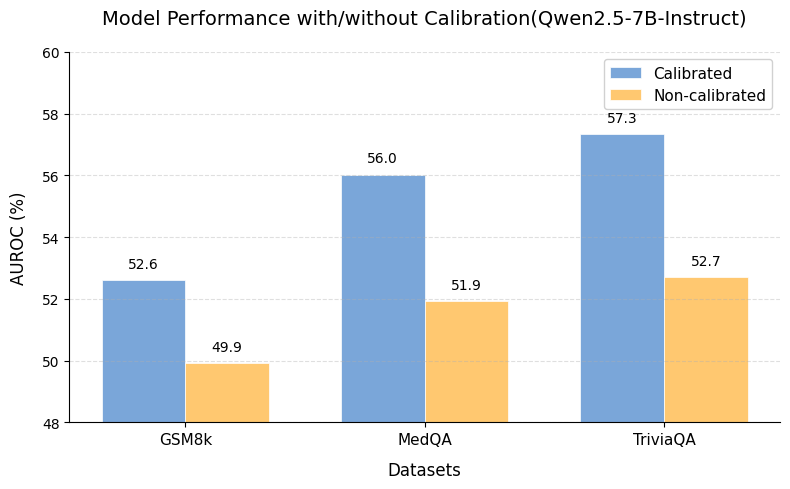

In [ ]:
#
# def plot_bar_plot(model_names: List):
datasets = ["GSM8k", "MedQA", "TriviaQA"]
qwen = [[52.60, 49.93], [56.02, 51.93], [57.33, 52.70]]


calibrated = [x[0] for x in qwen]
non_calibrated = [x[1] for x in qwen]

# 绘图参数
bar_width = 0.35
x = np.arange(len(datasets))
colors = ["#7AA6D9", "#FFC870"]  # 修改为浅色版本


plt.figure(figsize=(8, 5))

# 绘制柱状图
bars1 = plt.bar(
    x - bar_width / 2,
    calibrated,
    width=bar_width,
    label="Calibrated",
    color=colors[0],
    edgecolor="white",
    linewidth=0.5,
)
bars2 = plt.bar(
    x + bar_width / 2,
    non_calibrated,
    width=bar_width,
    label="Non-calibrated",
    color=colors[1],
    edgecolor="white",
    linewidth=0.5,
)

# 标签和标题
plt.xlabel("Datasets", fontsize=12, labelpad=10)
plt.ylabel("AUROC (%)", fontsize=12, labelpad=10)
plt.title(
    "Model Performance with/without Calibration(Qwen2.5-7B-Instruct)",
    fontsize=14,
    pad=20,
)
plt.xticks(x, datasets, fontsize=11)
plt.yticks(fontsize=10)
plt.legend(framealpha=0.9, fontsize=11)


# 智能文本标签位置
def autolabel(bars, offset=0.3):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + offset,
            f"{height:.1f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )


autolabel(bars1)
autolabel(bars2)

# 美化设置
plt.ylim(48, 60)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("outputs/auroc_qwen_medqa.pdf", dpi=800)

plt.show()